In [1]:
from __future__ import division

import pandas as pd
import numpy as np
#import html2text
from datetime import date
import random
from os import walk
import os

#Packages for pulling text data 
from urllib.request import urlopen  # the lib that handles the url stuff
from bs4 import BeautifulSoup
import pandas.io.data as web
from pandas.tseries.offsets import BDay

#Packages for text data processing
import nltk, re, pprint
#nltk.download()
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

#Packages for statistical learning 
from sklearn.preprocessing import normalize as Normal
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline

import imp

import Text_Analytics as TA

C:\Users\ziyi\Anaconda3\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
#Setup working directory 
os.chdir("C:/Users/ziyi/Documents/Inde project/Independent Study Anseri-20170120T004329Z/Independent Study Anseri") 
MIDCAP=pd.read_excel('8K data/MID Index.xlsx')

In [3]:
MIDCAP.columns=['Ticker', 'Name', 'Market Cap', 'GICS Sector']

In [4]:
sector_count=MIDCAP['GICS Sector'].value_counts()
sector_count=pd.DataFrame(sector_count)

In [5]:
sector_count

,GICS Sector
Information Technology,67
Financials,60
Consumer Discretionary,60
Industrials,58
Real Estate,39
Materials,30
Health Care,29
Energy,20
Consumer Staples,18
Utilities,18


## Part I: Pull Text (8K) and Price data from the web - 01/01/2013-31/12/2016

for x in sector_count.index:
    
    print(x)
    
    MIDCAP_40=MIDCAP[MIDCAP['GICS Sector']==x]
    MIDCAP_40.Name=MIDCAP_40.Name.apply(lambda x: x.upper())
    
    #Pull 8K text data from SEC
    df=pd.DataFrame()
    
    DATA_READ_FROM = "8K data/Index_Files/Part1"
    FILE_LIST = []
    for (dirpath, dirnames, filenames) in walk(DATA_READ_FROM):
        FILE_LIST.extend(filenames)
    for file in FILE_LIST: #read file by file
        #parse table
        idx = pd.read_table(DATA_READ_FROM+'/'+file, skiprows=4,sep='|')
        idx=idx.iloc[1:,:]
        #select news for the 40 stocks
        idx_midcap=idx[idx['Company Name'].apply(lambda x:x in MIDCAP_40.Name.tolist())]
        df=df.append(idx_midcap)

    DATA_READ_FROM = "8K data/Index_Files/Part2"
    FILE_LIST = []
    for (dirpath, dirnames, filenames) in walk(DATA_READ_FROM):
        FILE_LIST.extend(filenames)

    for file in FILE_LIST: #read file by file
        #parse table
        idx = pd.read_table(DATA_READ_FROM+'/'+file, skiprows=5,sep='|')
        idx=idx.iloc[1:,:]
        #select news for the 40 stocks
        idx_midcap=idx[idx['Company Name'].apply(lambda x:x in MIDCAP_40.Name.tolist())]
        df=df.append(idx_midcap)

    df=df[df['Form Type']=='8-K']
    df['Text']=pd.Series(index=df.index)
    df.shape

    output="8K data/MID_Sectors/Input/"+x+"_list_files.csv"
    df.to_csv(output)
    
    #Pull stock price data from Yahoo or Google 
    Start=pd.to_datetime('2013-01-01',format='%Y-%M-%d')
    End=pd.to_datetime('2017-01-31',format='%Y-%M-%d')

    Database=pd.DataFrame()
    for ticker in MIDCAP_40.Ticker.tolist():
        ticker=ticker.split(' ')[0]
        print(ticker)
        try:
            price = web.DataReader(ticker, 'yahoo',Start ,End)['Close']
            price.name=ticker
            Database[ticker]=price
        except:
            try:
                price = web.DataReader(ticker,'google', Start ,End)['Close']
                price.name=ticker
                Database[ticker]=price
            except:
                pass
            
    output_price="8K data/MID_Sectors/Input/"+x+"_Price.csv"
    Database.drop(Database.columns[np.isnan(Database).sum()>0],axis=1).to_csv(output_price)

In [6]:
MIDCAP.Ticker=MIDCAP.Ticker.apply(lambda x:x.split(" ")[0])
Tik_Name=MIDCAP[["Ticker","Name"]]
Tik_Name.Name=Tik_Name.Name.apply(lambda x:x.upper())

C:\Users\ziyi\Anaconda3\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [7]:
sector_count.index

Index(['Information Technology', 'Financials', 'Consumer Discretionary',
       'Industrials', 'Real Estate', 'Materials', 'Health Care', 'Energy',
       'Consumer Staples', 'Utilities', 'Telecommunication Services'],
      dtype='object')

## Part II: Extract Event Text from 8K Data

for y in sector_count.index[10:]:
    
    print(y)
    df=pd.read_csv("8K data/MID_Sectors/Input/"+y+"_list_files.csv",index_col=0)
    
    counter=0
    for x, row in df.iterrows():
        try:
            data = urlopen('http://www.sec.gov/Archives/'+row['Filename']).read()
            soup=BeautifulSoup(data, 'html.parser')
            if(row['Form Type']=='4'):
                df.loc[x,'Text']=soup.footnotes.get_text()
            elif(row['Form Type']=='8-K'):
                text=soup.body.get_text()
                beg=text.upper().find('ITEM',1)
                end=text.upper().find('SIGNATURE',1)
                df.loc[x,'Text']=text[beg:end]
            elif(row['Form Type']=='SC 13G/A'):
                df.loc[x,'Text']==soup.document.get_text()
            elif(row['Form Type']=='10-K' or row['Form Type']=='10-Q'):
                text=soup.body.get_text()
                beg=text.upper().find('MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS',10000)
                end=text.upper().find('QUANTITATIVE AND QUALITATIVE DISCLOSURES ABOUT MARKET RISK',10000)
                df.loc[x,'Text']=text[beg:end]
            else:
                continue    

        except:
            pass

        if (counter%100==0):
            print (counter, df.shape[0]) 
        counter+=1
        
    index=df.index

    df.Text=df.Text.astype(str)
    df.Text=df.Text.apply(lambda x:x.upper())
    df.Text=df.Text.apply(lambda x:x.replace('\xa0',' '))

    #Add Ticker column
    df=df.merge(Tik_Name,how="left",left_on="Company Name",right_on="Name")
    df.index=index
    df=df.drop(["Name"],axis=1)
    
    output="8K data/MID_Sectors/Input/"+y+"_text.csv"
    df.to_csv(output,encoding = 'utf-8' )
    

## Part III: Get Event List TS for Each Sector

In [8]:
events_list=("ITEM 1.01","ITEM 1.02","ITEM 1.03","ITEM 1.04",
             "ITEM 2.01","ITEM 2.02","ITEM 2.03","ITEM 2.04","ITEM 2.05","ITEM 2.06",
             "ITEM 3.01","ITEM 3.02","ITEM 3.03",
             "ITEM 4.01","ITEM 4.02",
             "ITEM 5.01","ITEM 5.02","ITEM 5.03","ITEM 5.04","ITEM 5.05","ITEM 5.06","ITEM 5.07","ITEM 5.08",
             "ITEM 6.01","ITEM 6.02","ITEM 6.03","ITEM 6.04","ITEM 6.05",
             "ITEM 7.01",
             "ITEM 8.01",
             "ITEM 9.01"            
            )

#Time Range under study
Time_range=pd.date_range("2013-01-01","2016-12-31",freq="D")

In [10]:
for x in sector_count.index:
    print(x)
    
    df=pd.read_csv("8K data/MID_Sectors/Input/"+x+"_text.csv",index_col=0,encoding="utf-8")
    Index=MIDCAP[MIDCAP['GICS Sector']==x]
    Index["Weight"]=Index["Market Cap"]/sum(Index["Market Cap"])
    Index["Name"]=Index["Name"].apply(lambda x:x.upper())
    
    Events_df=TA.Doc_Events(df,events_list)
    Events_ts=TA.Index_Events(Events_df,Index,Time_range)
    
    Index.to_csv("8K data/MID_sectors/Input/"+x+"_index.csv")
    Events_df.to_csv("8K data/MID_sectors/Input/"+x+"_events.csv")
    Events_ts.to_csv("8K data/MID_Sectors/Input/"+x+"_ts_events.csv")

Information Technology


C:\Users\ziyi\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ziyi\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Financials
Consumer Discretionary
Industrials
Real Estate
Materials
Health Care
Energy
Consumer Staples
Utilities
Telecommunication Services


ValueError: labels ['CIK'] not contained in axis

## Part IV: Extract Event Text 

In [117]:
#Setup Item Parameters 
Item="2.02"
item="ITEM"+" "+Item

#Setup Output Parameters
itemb="202"
add1='8K Data/Output/tfidf_ITEM'+itemb+".csv"
add2='8K Data/Output/keyword_ITEM'+itemb+".csv"
add3='8K Data/Output/SPCA_ITEM'+itemb+'.csv'
add4='8K Data/Output/Dict_ITEM'+itemb+'.csv'

In [118]:
ITEM_docs_tojoin=[]

for x in sector_count.index[:-1]:
    print(x)
    df=pd.read_csv("8K data/MID_Sectors/Input/"+x+"_text.csv",index_col=0,encoding="utf-8")
    df=df[-pd.isnull(df.Text)] #remove invalid rows
    Events_df=pd.read_csv("8K data/MID_sectors/Input/"+x+"_events.csv",index_col=0)
    
    ITEM_list=TA.get_event_doc(Events_df,item)
    ITEM_docs=df.loc[ITEM_list]
    ITEM_docs["ITEM_text"]=ITEM_docs.Text.apply(lambda x:TA.get_event_text(x,item))
    ITEM_docs.drop("Text",axis=1,inplace=True)
    ITEM_docs["ITEM_words"]=ITEM_docs["ITEM_text"]
    for i,row in ITEM_docs.iterrows():
        ITEM_docs.loc[i,"ITEM_words"]=TA.clean_text(row["ITEM_text"],row["Company Name"])
    ITEM_docs["ITEM_nouns"]=ITEM_docs.ITEM_words.apply(lambda x:TA.get_noun(x))

    ITEM_docs_tojoin.append(ITEM_docs)    

Information Technology


C:\Users\ziyi\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ziyi\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ziyi\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ziyi\Anaconda3\lib\site-package

Financials
Consumer Discretionary
Industrials
Real Estate
Materials
Health Care
Energy
Consumer Staples
Utilities


In [119]:
ITEM_docs= pd.concat(ITEM_docs_tojoin)

ITEM_list=TA.get_event_doc(Events_df,item)
ITEM_docs=df.loc[ITEM_list]
ITEM_docs["ITEM_text"]=ITEM_docs.Text.apply(lambda x:TA.get_event_text(x,item))
ITEM_docs.drop("Text",axis=1,inplace=True)
ITEM_docs["ITEM_words"]=ITEM_docs["ITEM_text"]
for i,row in ITEM_docs.iterrows():
    ITEM_docs.loc[i,"ITEM_words"]=TA.clean_text(row["ITEM_text"],row["Company Name"])
    ITEM_docs["ITEM_nouns"]=ITEM_docs.ITEM_words.apply(lambda x:TA.get_noun(x))

### Text Representation: Bag of Words

In [120]:
#get bag of words
vectorizer = CountVectorizer( analyzer='word',tokenizer = None, preprocessor = None,stop_words = None,max_features = 5000)
X=vectorizer.fit_transform(ITEM_docs.ITEM_nouns.tolist())
print (len(vectorizer.get_feature_names())) #1171 features 
print (X.toarray())
print ((np.sum(X.toarray(),0)))

2689
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[  1   1 381 ...,   2   1   3]


C:\Users\ziyi\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


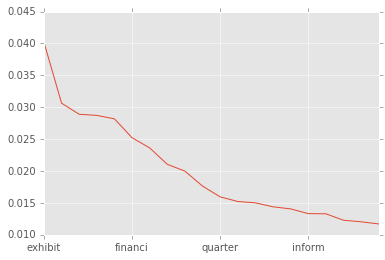

In [121]:
ITEM_dict=pd.DataFrame({"Freq":[0]*len(vectorizer.get_feature_names())},index=vectorizer.get_feature_names())
ITEM_dict["Freq"]=np.sum(X.toarray(),0)
ITEM_dict["Freq_pct"]=ITEM_dict["Freq"]/sum(ITEM_dict["Freq"])

ITEM_dict=ITEM_dict.sort(['Freq'], ascending=[False])

ITEM_dict["Freq_pct"][:20].plot(x=ITEM_dict.index,y="Freq_pct")

In [122]:
ITEM_dict.to_csv(add4,index_col=0)

In [109]:
# get tf-idf table
transformer = TfidfTransformer(smooth_idf=True)
tf_idf=transformer.fit_transform(X)
tfidf_df=pd.DataFrame(tf_idf.toarray(), index=ITEM_docs.index, columns=vectorizer.get_feature_names())
tfidf_df[['CIK','Company Name','Date Filed']]=ITEM_docs[['CIK','Company Name','Date Filed']].copy()
tfidf_df.head()

,abil,abl,acb,acceler,accept,access,accord,accordingli,accordion,account,...,word,work,worth,www,year,yield,york,CIK,Company Name,Date Filed
15594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1078075,NETSCOUT SYSTEMS INC,2015-07-15
196654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,898293,JABIL CIRCUIT INC,2015-07-10
233543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.019799,310568,MICROSEMI CORP,2016-01-19
203598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,749251,GARTNER INC,2016-06-17
232980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,910638,3D SYSTEMS CORP,2016-05-02


Key_df=TA.Doc_Keywords(ITEM_docs, tfidf_df[vectorizer.get_feature_names()], 10)
Key_df

In [111]:
tfidf_df.to_csv(add1)
#Key_df.to_csv(add2)

### Text Representation: SPARSE PCA

In [112]:
from sklearn import decomposition
SPCA=decomposition.SparsePCA(n_components=30,alpha=0.3,ridge_alpha=0)
SPCA.fit(tfidf_df.iloc[:,:-3])
SPCA.components_

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [113]:
np.sum(SPCA.components_!=0,axis=1)

array([ 7, 14,  1,  4,  7,  3,  1,  5,  5,  3,  4,  4,  4,  3,  6,  2,  0,
        2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [114]:
SPCA.error_[-1]

50.273326265594932

In [115]:
SPCA_df=pd.DataFrame(SPCA.components_, columns=tfidf_df.iloc[:,:-3].columns)
SPCA_keywords=[]
for i,row in SPCA_df.iterrows():
    SPCA_keywords.append(TA.get_Keywords(row,20))
    print(TA.get_Keywords(row,20))

['period', 'person', 'perform', 'pennsylvania', 'permit', 'personnel', 'pca', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
['item', 'oblig', 'creation', 'sheet', 'financi', 'herein', 'balanc', 'inform', 'definit', 'registr', 'materi', 'incorpor', 'refer', 'requir', nan, nan, nan, nan, nan, nan]
['merger', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
['note', 'indentur', 'truste', 'redempt', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
['personnel', 'pierc', 'person', 'period', 'phrase', 'place', 'percentag', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
['person', 'phrase', 'permit', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
['astoria', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
['person', 'phrase', 'permit', 'perform', 'personnel', nan, nan, nan, nan, nan, nan, nan, nan

In [116]:
pd.DataFrame(SPCA_keywords).to_csv(add3)

col_names=['Topic'+str(i) for i in np.arange(0,SPCA_df.shape[0])]
Topics=pd.DataFrame(SPCA.transform(tfidf_df.iloc[:,:-3]),index=tfidf_df.index, columns=col_names)
Topics[['CIK','Company Name','Date Filed']]=df[['CIK','Company Name','Date Filed']].copy()

Topics

Topics.to_csv(add3)

## Part V: Premilinary Regression with Text Data

In [ ]:
#Import Data
df_text=pd.read_csv("8K data/events_ts_Info.csv",parse_dates=True,index_col=0)
df_return=pd.read_csv("8K data/Price_ts_Info.csv",parse_dates=True,index_col=0)

In [ ]:
df_text=df_text.loc[df_return.index]

### Linear Regression

In [ ]:
Y=df_return.iloc[2:,1].as_matrix()
X_text=df_text.iloc[1:-1,:]
X_return=df_return.iloc[1:-1,1]
X=pd.concat([X_text,X_return],axis=1)
X

In [ ]:
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

In [ ]:
#Setup Item Parameters 
Item="2.02"
item="ITEM"+" "+Item
itemb="202"
add0='8K Data/tfidf_ITEM'+itemb+".csv"
Ykind='Vol_Ratio'

## One week effect on volatility

In [ ]:
#Import Data
df2=pd.read_csv("8K data/list_40.csv", index_col=0)
df=pd.read_csv(add0, index_col=0)
df['Date Filed']=df['Date Filed'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d').date())

In [ ]:
KA=TA.KeywordAnalyzer(df,df2)

In [ ]:
# pull stock return as label
Y=KA.get_Y(kind=Ykind)

In [ ]:
df_temp=df.drop(['CIK','Company Name','Date Filed'],axis=1).copy()
X_text=Normal(df_temp.as_matrix(),axis=1)

In [ ]:
#pd.DataFrame(X_ts).to_csv(addX1)
pd.DataFrame(X_text).to_csv(addX2)
pd.DataFrame(Y).to_csv(addY)

In [ ]:
X_text=pd.read_csv(addX2,index_col=0)
Y=pd.read_csv(addY,index_col=0)

In [ ]:
X_text.columns=df_temp.columns

### Lasso Regression

#### Text Only

In [ ]:
#construct model and predict
X=X_text.as_matrix()
Y=Y.reshape(Y.shape[0],)

X_train,Y_train=TA.get_train(X,Y,1.0)
X_test=X_train
Y_test=Y_train

best_param=TA.Lasso_param(X_train,Y_train)
lasso =linear_model.Lasso(alpha=best_param)
lasso.fit(X_train,Y_train)
pred=lasso.predict(X_test)

In [ ]:
best_param

In [ ]:
print(lasso.coef_)
print(lasso.intercept_)
print(pred)

In [ ]:
Comp=pd.DataFrame({"Y":Y_test,
                  "Pred":pred})
Comp["Error"]=abs(Comp["Y"]-Comp["Pred"])
Comp

In [ ]:
plt.figure()
Comp[["Pred","Y"]].plot()

#### SVR Regression

In [ ]:
X_train,Y_train=TA.get_train(X,Y,1.0)
X_test=X_train
Y_test=Y_train

best_param=TA.SVR_param(X_train,Y_train)
svr = SVR(kernel='linear',C=np.exp(best_param),epsilon=0.01)
svr.fit(X_train,Y_train)
pred=svr.predict(X_test)

In [ ]:
coefs=svr.coef_
coefs=coefs.reshape(coefs.shape[1],)
print(svr.intercept_)

In [ ]:
SVR_coefs=pd.DataFrame({"Weight":coefs},index=X_text.columns)
SVR_coefs["Abs_weight"]=abs(SVR_coefs["Weight"])
SVR_coefs=SVR_coefs.sort_values(["Abs_weight"],ascending=[False])
toexport=SVR_coefs[:50]
#pd.DataFrame(toexport).to_csv("8K Data\keywords_ITEM202.csv")

In [ ]:
df[df["conditionon"]!=0][["ebitda","Company Name"]]

In [ ]:
Comp=pd.DataFrame({"Y":Y_test,
                  "Pred":pred})
Comp["Error"]=abs(Comp["Y"]-Comp["Pred"])
Comp

In [ ]:
plt.figure()
with pd.plot_params.use('x_compat', True):
    Comp.Pred.plot(color="b",legend=True)
    Comp.Y.plot(color="grey",legend=True)
    
plt.xlabel("Text")